# Подключаем библиотеки

In [1]:
from math import pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import re
from datetime import datetime
from datetime import timedelta
from datetime import time
from torch.utils.data import Dataset, DataLoader
import torch
from torch import Tensor
from torch.nn import Module, Linear, Sigmoid, LeakyReLU, Tanh, Dropout1d, Sequential, L1Loss, MSELoss
from torch.optim import Adam, SGD

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Считываем и выводим данные

In [3]:
df_business = pd.read_excel('Train.xlsx', sheet_name='business')
df_business['class'] = np.ones(df_business.shape[0])
df_economy = pd.read_excel('Train.xlsx', sheet_name='economy')
df_economy['class'] = np.zeros(df_economy.shape[0])

In [4]:
df = pd.concat([df_business, df_economy], axis=0)
df.shape

(240208, 12)

Удаляем дубликаты

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(240208, 12)

Перемешиваем таблицу

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,"28,510",1.0
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,"4,896",0.0
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,"8,641",0.0
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,"4,496",0.0
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,"3,374",0.0


In [7]:
df.shape

(240208, 12)

# Обработка данных

Приведём столбец цены к типу данных float

In [8]:
df['price'] = df['price'].apply(lambda x: float(x.replace(',', '')))

Очистка от выбросов

In [9]:
q1, q3 = df['price'].quantile(0.25), df['price'].quantile(0.75)
d = q3 - q1
lower, upper = q1 - d, q3 + d
print(lower, upper)
df = df[(df['price'] > lower) & (df['price'] < upper)]
df.shape

-32955.0 80259.0


(238583, 12)

Приводим строки к соответствующему формату

In [10]:
df = df.astype({'airline': 'string', 'ch_code': 'string', \
                'from': 'string', 'to': 'string'})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238583 entries, 0 to 240207
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        238583 non-null  object 
 1   airline     238583 non-null  string 
 2   ch_code     238583 non-null  string 
 3   num_code    238583 non-null  int64  
 4   dep_time    238583 non-null  object 
 5   from        238583 non-null  string 
 6   time_taken  238583 non-null  object 
 7   stop        238583 non-null  object 
 8   arr_time    238583 non-null  object 
 9   to          238583 non-null  string 
 10  price       238583 non-null  float64
 11  class       238583 non-null  float64
dtypes: float64(2), int64(1), object(5), string(4)
memory usage: 23.7+ MB


Функция приведения столбца с описанием пересадок в структурированных вид

0 - без пересадок

1 - 1 пересадка

2 - 2 и более пересадок

In [12]:
def text_to_stop_categories(text:str):
    if text[0] == 'n':
        return 0
    elif text[0] == '1':
        return 1
    return 2

Функция определения, является ли время ночным или дневным (0 - ночь, 1 - день)

In [13]:
def time_to_daytime(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M')
    if time_obj.hour >= 8 and time_obj.hour < 20:
        return 1
    return 0

Функция подсчёта количества минут

In [14]:
def time_to_minutes(time_str:str):
    time_obj = re.findall(r'\d{1,}', time_str)
    return int(time_obj[0]) * 60 + int(time_obj[1])

Применяем к нужным столбцам соответствующие изменения

Преобразуем авиалинию и ch_code в бинарный признак

In [15]:
df['stop_categories'] = df['stop'].apply(text_to_stop_categories)
df['dep_time_category'] = df['dep_time'].apply(time_to_daytime)
df['arr_time_category'] = df['arr_time'].apply(time_to_daytime)
df['time_taken_minutes'] = df['time_taken'].apply(time_to_minutes)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,stop_categories,dep_time_category,arr_time_category,time_taken_minutes
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,28510.0,1.0,0,0,0,150
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,4896.0,0.0,1,1,1,535
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,8641.0,0.0,1,0,1,1340
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,4496.0,0.0,1,1,0,685
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,3374.0,0.0,1,1,1,235


Теперь закодируем признак, обозначающий количество пересадок, с помощью вектора из нулей и единиц

In [16]:
stop_category_encoder = OneHotEncoder()
stop_category_encoder.fit(df[['stop_categories']])
df[['stop0', 'stop1', 'stop2']] = stop_category_encoder.transform(df[['stop_categories']]).toarray()

Аналогичным образом закодируем признак авиакомпании

In [17]:
airline_encoder = OneHotEncoder()
airline_encoder.fit(df[['airline']])
df[[f'airline_{i.replace(' ', '_').lower()}' for i in airline_encoder.categories_[0]]] = \
airline_encoder.transform(df[['airline']]).toarray()

Будем учитывать расстояния между городами

In [18]:
city_indexes = {'Bangalore': 0, 'Chennai': 1, 'Delhi': 2, \
                'Hyderabad': 3, 'Kolkata': 4, 'Mumbai': 5}
city_dists = [
    [     0,          290,          1720,           1680,          1550,            830  ],
    [   290,            0,          1760,           1840,          1360,           1050  ],
    [  1720,         1760,             0,           1250,          1300,           1160  ],
    [  1680,         1840,          1250,              0,          2060,            850  ],
    [  1550,         1360,          1300,           2060,             0,           1650  ],
    [  830,          1050,          1160,            850,          1650,              0  ]
]

In [19]:
df['dist'] = df.apply(lambda x: city_dists[city_indexes[x['from']]]\
                      [city_indexes[x['to']]], axis=1)

Закодируем время вылета и прилёта двумя числами

In [20]:
arr_time_angle = np.array(df['arr_time'].apply(time_to_minutes)).astype('float64')
arr_time_angle /= 60 * 24
arr_time_angle *= 2 * pi
dep_time_angle = np.array(df['dep_time'].apply(time_to_minutes)).astype('float64')
dep_time_angle /= 60 * 24
dep_time_angle *= 2 * pi
df['arr_time_x'] = np.cos(arr_time_angle)
df['arr_time_y'] = np.sin(arr_time_angle)
df['dep_time_x'] = np.cos(dep_time_angle)
df['dep_time_y'] = np.sin(dep_time_angle)

Посмотрим на результат

In [21]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,stop_categories,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,airline_air_india,airline_airasia,airline_go_first,airline_indigo,airline_spicejet,airline_starair,airline_trujet,airline_vistara,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,28510.0,1.0,0,0,0,150,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300,0.965926,-0.258819,0.608761,-0.793353
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,4896.0,0.0,1,1,1,535,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1720,-0.065403,-0.997859,-0.675590,0.737277
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,8641.0,0.0,1,0,1,1340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1840,0.480989,-0.876727,0.806445,-0.591310
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,4496.0,0.0,1,1,0,685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1720,0.691513,-0.722364,-0.793353,0.608761
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,3374.0,0.0,1,1,1,235,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1680,-0.737277,-0.675590,-0.960050,0.279829


# Подготовка данных

Разделим таблицу на признаки и целевую переменную

In [22]:
X = df[df.columns[11:]]
X.drop(columns='stop_categories', inplace=True)
y = df[['price']]

Разделим данные на тренировочные, валидационные и тестовые

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, \
                                                  random_state=42, shuffle=True)

# Проанализируем данные

Посмотрим на корреляцию между признаками

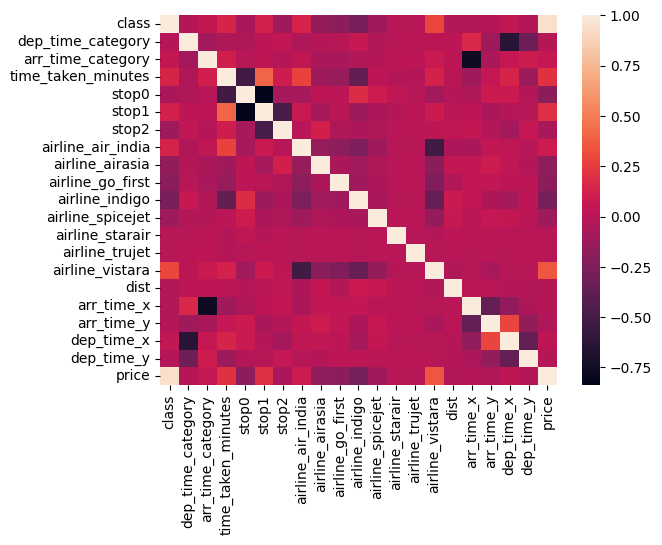

In [24]:
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr());

In [25]:
pd.DataFrame(pd.concat([X_train, y_train], axis=1).corr())

,class,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,airline_air_india,airline_airasia,airline_go_first,airline_indigo,airline_spicejet,airline_starair,airline_trujet,airline_vistara,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y,price
class,1.000000,-0.019117,0.043923,0.140585,-0.065375,0.118115,-0.110322,0.134135,-0.158729,-0.193231,-0.274528,-0.116828,-0.009652,-0.008358,0.292679,-0.030407,-0.028835,-0.018225,0.033844,-0.023536,0.943094
dep_time_category,-0.019117,1.000000,-0.092775,-0.039542,-0.035793,0.011943,0.035631,-0.033326,-0.022024,-0.006466,0.063448,-0.031762,-0.009022,0.009746,0.009262,0.015172,0.155071,-0.117560,-0.636398,-0.315151,-0.013772
arr_time_category,0.043923,-0.092775,1.000000,0.103353,-0.008765,0.018301,-0.019282,0.030396,-0.064317,-0.073340,-0.032185,-0.013225,0.003464,0.010303,0.068815,0.017397,-0.769503,-0.058193,0.051942,0.088677,0.046378
time_taken_minutes,0.140585,-0.039542,0.103353,1.000000,-0.515420,0.402225,0.093731,0.278498,-0.106808,-0.139477,-0.365574,0.010243,-0.019821,-0.014852,0.131601,0.007030,-0.105167,0.047745,0.140370,-0.120668,0.209503
stop0,-0.065375,-0.035793,-0.008765,-0.515420,1.000000,-0.836921,-0.078878,-0.077579,0.022484,0.015978,0.175358,0.081712,0.024754,-0.004652,-0.102815,-0.022965,-0.036494,0.075577,0.073183,-0.020309,-0.185803
stop1,0.118115,0.011943,0.018301,0.402225,-0.836921,1.000000,-0.479604,0.069811,-0.082642,0.007757,-0.125392,-0.051469,-0.020099,0.005558,0.078216,0.006386,0.010209,-0.057425,-0.017088,-0.007823,0.203109
stop2,-0.110322,0.035631,-0.019282,0.093731,-0.078878,-0.479604,1.000000,-0.002775,0.114475,-0.039745,-0.052752,-0.037259,-0.003078,-0.002666,0.022376,0.025188,0.039913,-0.016576,-0.086206,0.046810,-0.072054
airline_air_india,0.134135,-0.033326,0.030396,0.278498,-0.077579,0.069811,-0.002775,1.000000,-0.145215,-0.176779,-0.251154,-0.106881,-0.008830,-0.007647,-0.521736,-0.050865,-0.057994,0.042448,0.026013,-0.005643,0.086927
airline_airasia,-0.158729,-0.022024,-0.064317,-0.106808,0.022484,-0.082642,0.114475,-0.145215,1.000000,-0.069014,-0.098050,-0.041726,-0.003447,-0.002985,-0.203686,0.045315,0.037521,0.088182,0.034805,-0.016421,-0.175650
airline_go_first,-0.193231,-0.006466,-0.073340,-0.139477,0.015978,0.007757,-0.039745,-0.176779,-0.069014,1.000000,-0.119363,-0.050796,-0.004197,-0.003634,-0.247959,-0.027054,0.037697,0.035167,0.012317,0.014162,-0.194560


# Нормализация данных

Проведём нормализацию данных

In [28]:
time_taken_minutes_scaler = MinMaxScaler()
X_train['time_taken_minutes'] = \
time_taken_minutes_scaler.fit_transform(X_train[['time_taken_minutes']])
X_val['time_taken_minutes'] = \
time_taken_minutes_scaler.transform(X_val[['time_taken_minutes']])
X_test['time_taken_minutes'] = \
time_taken_minutes_scaler.transform(X_test[['time_taken_minutes']])

dist_scaler = MinMaxScaler()
X_train['dist'] = dist_scaler.fit_transform(X_train[['dist']])
X_val['dist'] = dist_scaler.transform(X_val[['dist']])
X_test['dist'] = dist_scaler.transform(X_test[['dist']])
X_val.head()

,class,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,airline_air_india,airline_airasia,airline_go_first,airline_indigo,airline_spicejet,airline_starair,airline_trujet,airline_vistara,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y
130296,1.0,1,0,0.091837,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.830508,0.971342,-0.237686,-0.065403,-0.997859
91097,0.0,0,1,0.170068,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.604520,-0.422618,-0.906308,-0.300706,0.953717
62145,0.0,1,1,0.556122,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570621,-0.876727,-0.480989,-0.843391,0.537300
48824,0.0,0,1,0.129252,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.785311,-0.923880,-0.382683,-0.087156,0.996195
224981,1.0,1,0,0.039116,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.807910,0.915311,-0.402747,0.422618,-0.906308


In [29]:
price_scaler = MinMaxScaler()
y_train['price'] = price_scaler.fit_transform(y_train[['price']])
y_val['price'] = price_scaler.transform(y_val[['price']])
y_test['price'] = price_scaler.transform(y_test[['price']])
y_test.head()

,price
105266,0.019842
136404,0.613080
8709,0.468136
133584,0.677047
133842,0.077635


# Подготовка датасета для нейронной сети

Создаём объекты для загрузки данных

In [30]:
class TicketsDataset(Dataset):
    def __init__(self, data_table: pd.DataFrame, targets: pd.DataFrame):
        self.data_table = data_table
        self.targets = targets
        assert self.data_table.shape[0] == self.targets.shape[0]
    def __len__(self):
        return self.targets.shape[0]
    def __getitem__(self, index):
        return Tensor(self.data_table.iloc[index]), Tensor(self.targets.iloc[index])

In [31]:
batch_size = 100

In [277]:
train_dataset = TicketsDataset(X_train, y_train)
val_dataset = TicketsDataset(X_val, y_val)
test_dataset = TicketsDataset(X_test, y_test)

In [278]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

# Создаём и обучаем нейронную сеть

In [216]:
class Network(Module):
    def __init__(self, n_of_features):
        super().__init__()
        hidden = 500
        self.layers = Sequential(
            Linear(n_of_features, hidden),
            Sigmoid(),
            Linear(hidden, 1)
        )
        self.quadratic = torch.nn.Bilinear(n_of_features, n_of_features, 1)
        self.norm = torch.nn.BatchNorm1d(X_train.shape[1])
    def forward(self, x):
        return torch.abs(self.layers(self.norm(x + self.quadratic(x, x))))

In [217]:
model = Network(X.shape[1])

In [218]:
loss_hist = []

In [221]:
epochs = 1

loss_fn = MSELoss()
optim = Adam(model.parameters(), weight_decay=0.01, lr=0.0003)
#optim = SGD(model.parameters(), weight_decay=0.01)

for e in range(1, epochs + 1):
    for i, [data_input, target_output] in enumerate(train_dataloader):
        model.train()
        data_pred = model(data_input)
        loss = loss_fn(data_pred, target_output)
        loss.backward()
        #print(model.l1.weight.grad)
        optim.step()
        optim.zero_grad()
        #if (i + 1) % 10 == 0:
        print(f'Epoch: {e}, samples: {i * batch_size + len(data_input)}/{len(train_dataset)}, ' + \
        f'loss={np.sqrt(loss.item())}')#, mape=' + \
        #f'{mean_absolute_percentage_error(target_output, data_pred.detach())}')
    model.eval()
    data_input, target_output = next(iter(val_dataloader))
    data_pred = price_scaler.inverse_transform(model(data_input).detach())
    target_output = price_scaler.inverse_transform(target_output)
    loss = mean_absolute_percentage_error(target_output, data_pred)
    loss_hist.append(loss)

Epoch: 1, samples: 100/133606, loss=0.07229447433331093
Epoch: 1, samples: 200/133606, loss=0.07034199811151168
Epoch: 1, samples: 300/133606, loss=0.09733479043744113
Epoch: 1, samples: 400/133606, loss=0.06705618559594874
Epoch: 1, samples: 500/133606, loss=0.07486193311608501
Epoch: 1, samples: 600/133606, loss=0.07633675251717849
Epoch: 1, samples: 700/133606, loss=0.08606179687649791
Epoch: 1, samples: 800/133606, loss=0.0741320624547228
Epoch: 1, samples: 900/133606, loss=0.07871674310367986
Epoch: 1, samples: 1000/133606, loss=0.08608885462978658
Epoch: 1, samples: 1100/133606, loss=0.07681268654882904
Epoch: 1, samples: 1200/133606, loss=0.09447699045740318
Epoch: 1, samples: 1300/133606, loss=0.0681544433736477
Epoch: 1, samples: 1400/133606, loss=0.08624555902865173
Epoch: 1, samples: 1500/133606, loss=0.05681378106392466
Epoch: 1, samples: 1600/133606, loss=0.07178499219977066
Epoch: 1, samples: 1700/133606, loss=0.08404930233167292
Epoch: 1, samples: 1800/133606, loss=0.092

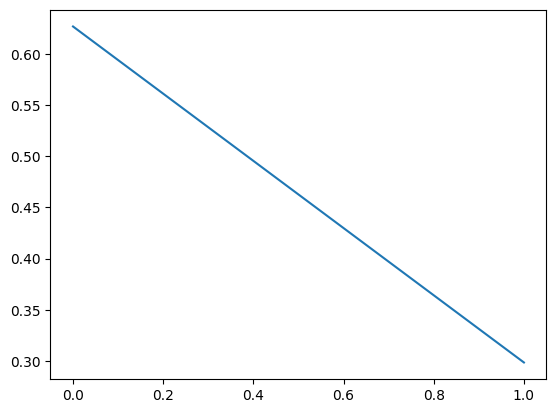

In [222]:
plt.plot(list(range(len(loss_hist))), loss_hist);

In [223]:
loss_hist

[0.6266569906600543, 0.29855347542460586]

In [225]:
torch.save(model, 'models/2/1')

In [274]:
features, target = next(iter(test_dataloader))
features

tensor([[ 1.0000e+00,  0.0000e+00,  1.0000e+00,  2.6531e-01,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          4.9153e-01,  4.6175e-01, -8.8701e-01,  6.1232e-17,  1.0000e+00]])

In [275]:
price_scaler.inverse_transform(target)

array([[36565.00083256]])

In [276]:
model.eval()
price_scaler.inverse_transform(model(features).detach())

array([[51618.50455666]])

In [232]:
city_dists[city_indexes['Delhi']][city_indexes['Mumbai']]

1160

In [83]:
city_indexes['Delhi']

2

In [84]:
city_indexes['Mumbai']

5

In [180]:
import torch

In [177]:
torch.save(model, 'model')

In [175]:
[(i, column) for i, column in enumerate(list(X_train.columns))]

[(0, 'class'),
 (1, 'dep_time_category'),
 (2, 'arr_time_category'),
 (3, 'time_taken_minutes'),
 (4, 'stop0'),
 (5, 'stop1'),
 (6, 'stop2'),
 (7, 'airline_air_india'),
 (8, 'airline_airasia'),
 (9, 'airline_go_first'),
 (10, 'airline_indigo'),
 (11, 'airline_spicejet'),
 (12, 'airline_starair'),
 (13, 'airline_trujet'),
 (14, 'airline_vistara'),
 (15, 'dist'),
 (16, 'arr_time_x'),
 (17, 'arr_time_y'),
 (18, 'dep_time_x'),
 (19, 'dep_time_y')]

In [171]:
X_train.shape[1]

20

In [ ]:
import numpy as np
from math import sin, cos, pi
from flask import Flask, request, jsonify
from flask_cors import CORS
import torch
from torch import Tensor
from datetime import datetime, timedelta



class Network(Module):
    def __init__(self, n_of_features):
        super().__init__()
        hidden = 64
        self.layers = Sequential(
            Linear(n_of_features, hidden),
            Sigmoid(),
            Linear(hidden, 1)
        )
    def forward(self, x):
        return self.layers(x)



model = torch.load('model')
model.eval()

with open('scalers', 'rb') as f:
    scalers = pickle.load(f)



city_indexes = {'Bangalore': 0, 'Chennai': 1, 'Delhi': 2, \
                'Hyderabad': 3, 'Kolkata': 4, 'Mumbai': 5}
city_dists = [
    [     0,          290,          1720,           1680,          1550,            830  ],
    [   290,            0,          1760,           1840,          1360,           1050  ],
    [  1720,         1760,             0,           1250,          1300,           1160  ],
    [  1680,         1840,          1250,              0,          2060,            850  ],
    [  1550,         1360,          1300,           2060,             0,           1650  ],
    [  830,          1050,          1160,            850,          1650,              0  ]
]

airlineNumbers = {'AirIndia': 7, 'AirAsia': 8,
       'GO FIRST': 9, 'Indigo': 10, 'SpiceJet': 11,
       'StarAir': 12, 'Trujet': 13, 'Vistara': 14}

app = Flask(__name__)
CORS(app, resources={r"/getTicket": {"origins": "http://localhost:5173"}})

@app.route('/getTicket', methods=['POST'])
def get_ticket():
    data = request.get_json()

    if not data:
        return jsonify({'error': 'No input data provided'}), 400

    position = data.get('position')
    positionTo = data.get('positionTo')
    classPlane = data.get('classPlane')
    airCompany = data.get('airCompany')
    countStops = int(data.get('countStops'))
    dataFrom = data.get('depFrom')
    dataTo = data.get('depTo')

    dist = city_dists[city_indexes[position]][city_indexes[positionTo]]
    dist = scalers[1].transform([[dist]])[0][0]
    cl = 0.0
    if classPlane == 'One':
        cl = 1.0

    dataFrom = datetime.strptime(dataFrom, '%Y-%m-%d %H:%M')
    dataTo = datetime.strptime(dataTo, '%Y-%m-%d %H:%M')

    fromAngle = (dataFrom.hour * 60 + dataFrom.minute) / (60 * 24) * 2 * pi
    toAngle = (dataTo.hour * 60 + dataTo.minute) / (60 * 24) * 2 * pi

    timeMinutes = (dataTo - dataFrom).seconds / 60.0
    timeMinutes = scalers[0].transform([[timeMinutes]])[0][0]

    input_data = torch.zeros(20)
    input_data[0] = cl
    if dataFrom.hour >= 8 and dataFrom.hour < 20:
        input_data[1] = 1
    if dataTo.hour >= 8 and dataTo.hour < 20:
        input_data[2] = 1
    input_data[3] = timeMinutes
    input_data[4 + countStops] = 1
    input_data[airlineNumbers[airCompany]] = 1
    input_data[15] = dist
    input_data[16] = cos(toAngle)
    input_data[17] = sin(toAngle)
    input_data[18] = cos(fromAngle)
    input_data[19] = sin(fromAngle)

    input_data = torch.unsqueeze(input_data, 0)

    answer = model(input_data).item()
    answer = scalers[2].inverse_transform([[answer]])[0][0]

    # Логика обработки данных
    #print(f"Position: {position}, PositionTo: {positionTo}, ClassPlane: {classPlane}")
    print(f'Price:{answer}')

    return jsonify({
        'message': 'Data received successfully',
        'data': {
            'position': position,
            'positionTo': positionTo,
            'classPlane': classPlane,
            'price': str(answer)
        }
    }), 200

if __name__ == '__main__':
    app.run(debug=True)

In [271]:
input_data = Tensor([[1, 1.0, 1.0, 180.0, 1.0, 0.0, 0.0, 0.5, -1.0, 0.0, -1.0, 0.0]])
model2 = torch.load('model')
#answer = model(input_data).item()

In [272]:
answer = model2(input_data)
answer.item()

37530.31640625

In [168]:
x1 = datetime.strptime('2024-6-3 12:08', '%Y-%m-%d %H:%M')
x2 = datetime.strptime('2024-6-3 13:08', '%Y-%m-%d %H:%M')
x = x2 - x1
x.seconds

3600

In [157]:
datetime.strptime?

Docstring: string, format -> new datetime parsed from a string (like time.strptime()).
Type:      builtin_function_or_method

In [ ]:
model.eval()
data_input, target_output = next(iter(val_dataloader))
data_pred = price_scaler.inverse_transform(model(data_input).detach())
target_output = price_scaler.inverse_transform(target_output)
loss = mean_absolute_percentage_error(target_output, data_pred)
loss